# **Vector Space Model (VSM) Evaluation Notebook**

## **Objective**
This notebook will serve as the testing site for comparing different **Vector Space Model (VSM) approaches** using various word embeddings.

## **Approaches Compared**
1. **Word2Vec Pretrained**  
2. **Word2Vec Fine-tuned (Pretrained + Own Data)**  
3. **Word2Vec Trained from Scratch on Own Data**  
4. **GloVe**  
5. **FastText**  

## **Evaluation Methods**
Each method will be evaluated using the following criteria:

### **A. Word Similarity Evaluation**
Measure the similarity between words using cosine similarity.

```python
print(word2vec_model.similarity("car", "vehicle"))
print(glove_model.similarity("car", "vehicle"))
print(custom_word2vec.wv.similarity("car", "vehicle"))
```

### **B. Document Vector Representation**
Compute document vectors by averaging the word embeddings of the words they contain.

```python
import numpy as np
from nltk.tokenize import word_tokenize

def get_document_vector(model, text):
    words = word_tokenize(text.lower())
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

doc_vector = get_document_vector(word2vec_model, "This is a test document.")
```

### **C. Clustering (K-Means)**
Cluster documents using K-Means clustering based on their computed document vectors.
```python
from sklearn.cluster import KMeans

# Example document vectors
doc_vectors = [get_document_vector(word2vec_model, doc) for doc in documents]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(doc_vectors)

print("Cluster assignments:", clusters)
```

### **D. Text Classification**
Use document embeddings as input for a classification model and evaluate its accuracy. (finally)


```python

```



--------------

In [3]:
import os
import numpy as np
import gensim.downloader as api

# Load the pretrained Word2Vec model
model = api.load("word2vec-google-news-300")  # Google's 300-dim Word2Vec

# Define the directory path
accessories_dir = "../02-data/01-pdfs/accessories"

# Initialize a dictionary to store document vectors
document_vectors = {}

# Iterate through all subdirectories
for root, dirs, files in os.walk(accessories_dir):
    for file in files:
        if file == "pdf.txt":  # Look for pdf.txt files
            file_path = os.path.join(root, file)

            # Read and preprocess the text file
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().split()  # Simple tokenization

            # Convert words to vectors
            word_vectors = [model[word] for word in text if word in model]
            
            # Compute document vector (mean of word embeddings)
            if word_vectors:
                doc_vector = np.mean(word_vectors, axis=0)
            else:
                doc_vector = np.zeros(model.vector_size)  # Default to zero vector if no words are found
            
            # Store the document vector using the file path as the key
            document_vectors[file_path] = doc_vector

# Print summary
print(f"Processed {len(document_vectors)} documents.")

Processed 19 documents.


--------------------------------------------
Save the model for later (or load)

In [4]:
import numpy as np

# Save the dictionary of document vectors as a NumPy file
np.save("../02-data/00-testing/vsm1.npy", document_vectors)


---------------------------------
This is the representation aspect of the code 

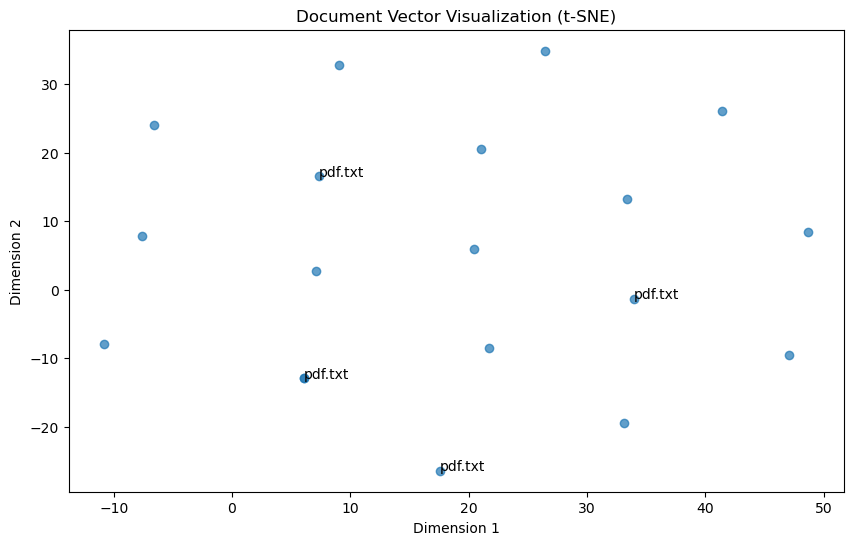

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract document vectors
doc_paths = list(document_vectors.keys())  # File paths as labels
doc_vectors = np.array(list(document_vectors.values()))  # Convert dict to array

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=min(30, len(doc_vectors) - 1), random_state=42)
doc_vectors_2d = tsne.fit_transform(doc_vectors)

# Plot the reduced vectors
plt.figure(figsize=(10, 6))
plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1], alpha=0.7)

# Annotate some points with filenames
for i, path in enumerate(doc_paths):
    if i % 5 == 0:  # Label every 5th document for readability
        plt.annotate(os.path.basename(path), (doc_vectors_2d[i, 0], doc_vectors_2d[i, 1]))

plt.title("Document Vector Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


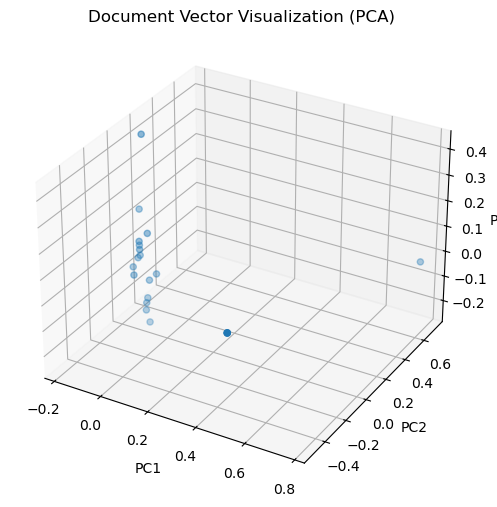

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D using PCA
pca = PCA(n_components=3)
doc_vectors_3d = pca.fit_transform(doc_vectors)

# Plot in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(doc_vectors_3d[:, 0], doc_vectors_3d[:, 1], doc_vectors_3d[:, 2])

ax.set_title("Document Vector Visualization (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


-------------------------------
How to "fine-tune" the word2vec?

1. Add the specific domain corpus to the main group of data
2. Retrain on this new extended corpus (adjust epochs and other variables)
3. Generate vectors as previously done

In [ ]:
new_data = [['your', 'new', 'data', 'tokens'], ['another', 'set', 'of', 'tokens']]
model.build_vocab(new_data, update=True)
model.train(new_data, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:
from gensim import downloader as api

import os
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Directory containing your text files
text_files_dir = "../02-data/01-pdfs/accessories"

# Collect all text data
sentences = []

for root, dirs, files in os.walk(text_files_dir):
    for file in files:
        if file.endswith(".txt"):  # Adjust if necessary
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip().lower() ## strip -removes leading and trailing whitespace.
                # Tokenize text (simple whitespace splitting, you could use nltk/spacy if more sophisticated tokenization is needed)
                sentences.append(text.split())

print(f"Collected {len(sentences)} documents.")

# Load the pretrained model
model = api.load("word2vec-google-news-300")

# Make the model trainable
model.init_sims(replace=True)  # Make the model's vectors mutable

# Update the model's vocabulary with new data
model.build_vocab(sentences, update=True) ## if a oov word appears (out-of-vocabulary) the word2vec skips the processing of said token. Wise to include it then

# Train the model on the new data
model.train(sentences, total_examples=len(sentences), epochs=model.epochs)

model.save("word2vec_finetuned.model") ## -> saves the model itself
model.wv.save("word2vec_finetuned.kv") ## -> saves the keyed vectors (if there is no need for further training)


## Now, use the model to create vector representations the same way as before --> look into 05-VSM


-------------------------------------
Now we are getting into other metrics (nearest neighbors for example)

In [6]:
import numpy as np
document_vectors = np.load("../02-data/00-testing/vsm1.npy", allow_pickle=True)

In [10]:
from sklearn.neighbors import NearestNeighbors

# Fit a nearest neighbor model on the document vectors
neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbors.fit(document_vectors)

# Query for the nearest neighbors of a specific document
query_document = document_vectors[0].reshape(1, -1)
distances, indices = neighbors.kneighbors(query_document)

print(f"Nearest neighbors for document 0: {indices[0]}")
print(f"Distances: {distances[0]}")


TypeError: float() argument must be a string or a real number, not 'dict'